* [新增欄位](#新增欄位)
* [成效特差與成效特好的影片](#成效特差與成效特好的影片)
* [依影片發布間隔分析](#依影片發布間隔分析)
* [依影片主題分析](#依影片主題分析)

 <a name="新增欄位"></a>
## 新增欄位

In [ ]:
# 分析的主要目標為讓YouTube頻道更受歡迎，作法包含隱藏成效差的影片、定標題策略、找尋成效較好的影片類型等等
import pandas as pd #讀取所需套件
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from pylab import mpl
import warnings
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(9,6)})
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
sns.set(font="SimSun")
plt.style.use('ggplot')
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
mpl.rcParams['axes.unicode_minus'] = False
pd.options.display.float_format = '{:,.4f}'.format
  
df=pd.read_excel('./raw/content.xlsx',dtype={'曝光次數':int,'影片發布時間':str,'曝光點閱率':float}) #讀取要分析的檔案

#對檔案做些預處理，以便後續分析
d=df.copy()
d=d.fillna('0')
d=d[d.內容 != '總計'] #排除總計欄，因為總計欄為過大的離群值，會影響圖表呈現
d=d[d.影片發布時間 != '0'] #排除不公開的影片
d=d[d.平均觀看時長 != '0'] #排除不公開的影片
d=d[d.內容 != '0']
d=d[d.曝光次數 != 0]
dfloat=[ 'YouTube Premium 觀看時間 (小時)',
       'YouTube Premium 觀看次數', '回訪的觀眾', '新觀眾', '資訊卡顯示次數', '資訊卡點擊次數', '訂閱人數',
       '分享次數', '流失的訂閱人數', '獲得的訂閱人數', '已新增留言', '不喜歡的人數', '喜歡的人數', '每位觀眾的平均觀看次數',
       '非重複觀眾人數', '平均觀看比例 (%)', '觀看次數', '觀看時間 (小時)', '曝光次數','曝光點閱率 (%)']
d[dfloat]=d[dfloat].astype(float)

d=d.rename(columns={'曝光點閱率 (%)':'曝光點閱率','平均觀看比例 (%)':'平均觀看比例',
                    '影片發布時間':'date','觀看時間 (小時)':'總觀看小時'})

d['曝光點閱率']=d['曝光點閱率']/100 #曝光點擊率換成小數點，後面比較好分析
d['平均觀看比例']=d['平均觀看比例']/100


d['date2']=pd.to_datetime(d['date'])
d['quarter']=pd.PeriodIndex(d.date2, freq='Q')
d['month']=d['date2'].dt.strftime('%Y-%m')

#計算影片時長
d['minute']=d['平均觀看時長'].str[2:4]
d['second']=d['平均觀看時長'].str[5:7]
d['minute']=d['minute'].astype(int)
d['second']=d['second'].astype(int)
d['觀看分鐘']=d['second']/60+d['minute'] #先把平均觀看比例轉換為分(欄位觀看比例)，以便後續計算

#把平均觀看分鐘除以觀看比例，得出影片時長，影片時長的誤差約在三秒內，應該是由於原始檔的平均觀看分鐘只給到小數點兩位
d['影片分鐘']=d['觀看分鐘']/d['平均觀看比例']
d=d.drop(columns={'minute','second'})

d=d.reset_index(drop=1)
d = d.fillna(0.0, axis=0) #NA取代為0

##觀看比例2
l, l2=[], []
num2=5
d=d.sort_values(by='影片分鐘',ascending=0).reset_index(drop=1)
for i in range(int(d.shape[0]/num2)+1):
    e = d.iloc[(i+1)*num2-num2:(i+1)*num2]['觀看分鐘'].mean()
    e2 = d.iloc[(i+1)*num2-num2:(i+1)*num2]['影片分鐘'].max()
    l.append(e)
    l2.append(e2)
     
l=pd.DataFrame(l,columns=['mean'])
l2=pd.DataFrame(l2,columns=['max1'])
l=pd.concat([l,l2],axis=1)
l['max1']=l['max1'].astype(str)
d.觀看分鐘=d.觀看分鐘.astype(str)
d.影片分鐘=d.影片分鐘.astype(str)
d=pd.merge(d,l,left_on='影片分鐘',right_on='max1',how='left')
d['mean']=d['mean'].ffill()

d['觀看分鐘']=d['觀看分鐘'].astype(float)
d['mean']=d['mean'].astype(float)
d['觀看比例2']=d['觀看分鐘']-d['mean']
d.影片分鐘=d.影片分鐘.astype(float)
d=d.sort_values(by='影片分鐘',ascending=0)
d[['影片標題','影片分鐘','平均觀看比例','觀看分鐘','觀看比例2','mean']].head(10) 
# PPT P3 - P7
# 新增欄位：觀看比例2
# 用於直觀地看出某部影片的平均觀看比例偏高還偏低
# 大於0偏高，小於0偏低
# 再把觀看時長減去平均得出觀看比例2
# 讓這些影片跟其他長度相近的影片去比較平均觀看比例

,影片標題,影片分鐘,平均觀看比例,觀看分鐘,觀看比例2,mean
0,用心良苦ㄉ泡芙(？【赤組逆襲】【忍豆風雲2 重製II】【第二次測試】 #懷舊系列 #私服,26.5190,0.0993,2.6333,-0.1600,2.7933
1,神扯佛滅的完整影片【語音場】【怪木城】【忍豆風雲3】,25.6410,0.0962,2.4667,-0.3267,2.7933
2,竟然湊到六人了，好感動【無課 PVP對戰】【忍豆風雲3】,25.4329,0.0924,2.3500,-0.4433,2.7933
3,還在挖地洞，快尬蛙ㄚ【語音場】【怪木城】【忍豆風雲3】,24.1569,0.1028,2.4833,-0.3100,2.7933
4,青鬼變BOSS了!? 極惡城1-6層【忍豆風雲2 重製】【極惡城】【公測】 #懷舊系列 #私服,22.5578,0.1788,4.0333,1.2400,2.7933
5,懶鬼鬼【絕命指令&拯救公主】【忍豆風雲2 重製II】【第二次測試】 #懷舊系列 #私服,18.5927,0.1748,3.2500,0.6400,2.6100
6,【忍豆風雲2 重製II】熟悉的赤組最...好弱【赤組逆襲 + 拯救公主】【第二次測試】 #懷...,17.6439,0.1842,3.2500,0.6400,2.6100
7,被高手虐ㄌQQ 語音場~【無課 PVP對戰】【忍豆風雲3】,17.2876,0.1369,2.3667,-0.2433,2.6100
8,神人示範一對三尬標【拯救公主】【忍豆風雲2 重製II】【第二次測試】 #懷舊系列 #私服,17.1180,0.1957,3.3500,0.7400,2.6100
9,窩在練習疊在一起【從零開始的忍3生活 Day 6】【忍豆風雲3】,16.9033,0.0493,0.8333,-1.7767,2.6100


In [ ]:
d['訂閱比例']=d['獲得的訂閱人數']/(d['獲得的訂閱人數']+d['流失的訂閱人數'])
d['訂閱比例2']=d['訂閱人數']/d['觀看次數']
d['喜歡比例']=d['喜歡的人數']/d['觀看次數']
# PPT P8
# 新增欄位：
# 訂閱比例 = 獲得的訂閱人數 / ( 獲得的訂閱人數 + 流失的訂閱人數 )

# 新增欄位：
# 訂閱比例2 = 訂閱人數 / 觀看次數
# 用於觀察觀眾看某部影片的觀眾的訂閱狀況
# 分母使用非訂閱者的觀看次數較有統計意義
# 不過無法從原始資料取得這項指標
# 分母只好先使用觀看次數

# 新增欄位：
# 喜歡比例 = 喜歡的人數 / 觀看次數
# 用於觀察觀眾看某部影片的觀眾點喜歡的狀況

 <a name="成效特差與成效特好的影片"></a>
## 成效特差與成效特好的影片

In [ ]:
n = 1.5
n2 = 0.1
n3 = 0.01
a=d[(d.訂閱比例2 < d.訂閱比例2.mean()/n) & (d.喜歡比例 < d.喜歡比例.mean()/n) & (d.觀看比例2 < 0 - n2) & (d.曝光點閱率 < d.曝光點閱率.mean() - n3)]
a['result'] = '成效特差'
a2= a[['影片標題','result']]
d2= pd.merge(d,a2,on='影片標題',how='left')
a[['影片標題', '訂閱比例2', '喜歡比例','觀看比例2','曝光點閱率']]
# PPT P9
# 成效特別差的影片：
# 可考慮設為不公開，以免這些影片降低頻道的整體曝光次數
# 包括訂閱比例低、喜歡比例低、觀看比例低、曝光點閱率低

,影片標題,訂閱比例2,喜歡比例,觀看比例2,曝光點閱率
0,用心良苦ㄉ泡芙(？【赤組逆襲】【忍豆風雲2 重製II】【第二次測試】 #懷舊系列 #私服,0.0000,0.0000,-0.1600,0.0360
15,13段單人打四星皆傳(多場)【從零開始的忍3生活 Day 5】【忍豆風雲3】,0.0000,0.0000,-0.4100,0.0275
20,万力鎖 VS 小太刀，語音場~【無課 PVP對戰】【忍豆風雲3】,0.0000,0.0000,-0.1033,0.0350
43,我們絕對不是在耍廢，我們是在找BUGㄛ【你死我活】【忍豆風雲2 重製II 私服】#懷舊系列,0.0000,0.0000,-0.3300,0.0356
47,10段打不二丸+銀次【從零開始的忍3生活 Day 2】【忍豆風雲3】,0.0000,0.0000,-0.2333,0.0291
51,一直跑的電腦好討厭R【一寸道場 千方島 第一關到第五關】【忍豆風雲3】,0.0000,0.0000,-0.4733,0.0248
56,瞬Oㄉ詛咒【拯救公主】【忍豆風雲2 重製II】【第二次測試】 #懷舊系列 #私服,0.0000,0.0000,-0.3300,0.0293
69,不要再卡我廁所ㄌQQ【忍豆風雲2 重製II 私服】【千人斬5】#懷舊系列,0.0000,0.0000,-0.2000,0.0312
70,紳士總是孤獨ㄉ【幻影篇之窩紳士ㄌ】【忍豆風雲3】,0.0000,0.0000,-0.3800,0.0309
107,拖台錢二人組(X【銀次 VS 首席陰陽師】【幻影篇之之窩會自爆 還有寫錯字】【忍豆風雲3】,0.0000,0.0000,-0.4500,0.0313


In [ ]:
n = 1
n2 = 0.05
n3 = 0.005

a=d[(d.訂閱比例2 < d.訂閱比例2.mean()/n) & (d.喜歡比例 < d.喜歡比例.mean()/n) & (d.觀看比例2 < 0 - n2) & (d.曝光點閱率 < d.曝光點閱率.mean() - n3)]
a['result2'] = '成效偏差'
a2= a[['影片標題','result2']]
d3= pd.merge(d2,a2,on='影片標題',how='left')
a[['影片標題', '訂閱比例2', '喜歡比例','觀看比例2','曝光點閱率']]
# PPT P11
# 成效偏差的影片

,影片標題,訂閱比例2,喜歡比例,觀看比例2,曝光點閱率
0,用心良苦ㄉ泡芙(？【赤組逆襲】【忍豆風雲2 重製II】【第二次測試】 #懷舊系列 #私服,0.0000,0.0000,-0.1600,0.0360
15,13段單人打四星皆傳(多場)【從零開始的忍3生活 Day 5】【忍豆風雲3】,0.0000,0.0000,-0.4100,0.0275
20,万力鎖 VS 小太刀，語音場~【無課 PVP對戰】【忍豆風雲3】,0.0000,0.0000,-0.1033,0.0350
31,爆爆王地圖之躲躲偷襲【千人斬】【忍豆風雲2 重製II】【第二次測試】 #懷舊系列 #私服,0.0000,0.0000,-0.0933,0.0246
36,煩人電腦的最高境界【一寸道場 千方島 第18關到第20關】【忍豆風雲3】,0.0000,0.0000,-0.6100,0.0385
39,小菜雞闖天叢雲【從零開始的忍3生活 Day 8】【忍豆風雲3】,0.0000,0.0000,-0.3600,0.0393
43,我們絕對不是在耍廢，我們是在找BUGㄛ【你死我活】【忍豆風雲2 重製II 私服】#懷舊系列,0.0000,0.0000,-0.3300,0.0356
47,10段打不二丸+銀次【從零開始的忍3生活 Day 2】【忍豆風雲3】,0.0000,0.0000,-0.2333,0.0291
51,一直跑的電腦好討厭R【一寸道場 千方島 第一關到第五關】【忍豆風雲3】,0.0000,0.0000,-0.4733,0.0248
53,尬標尬標【無課 影武者PVP對戰】【忍豆風雲3】,0.0000,0.0040,-0.1233,0.0395


In [ ]:
n = 1
n2 = 0
n3 = 0

a=d[(d.訂閱比例2 > d.訂閱比例2.mean()/n) & (d.喜歡比例 > d.喜歡比例.mean()/n) & (d.觀看比例2 > 0 - n2) & (d.曝光點閱率 > d.曝光點閱率.mean() - n3)]
a['result3'] = '成效特好'
a2= a[['影片標題','result3']]
d3= pd.merge(d3,a2,on='影片標題',how='left')
d3['result4'] = np.where(d3.result == '成效特差', '成效特差',
                         np.where(d3.result2 == '成效偏差' , '成效偏差', 
                           np.where(d3.result3 == '成效特好' , '成效特好', "一般")))
d3=d3.drop(columns=['result','result2','result3'])
a[['影片標題', '訂閱比例2', '喜歡比例','觀看比例2', '曝光點閱率']]
# PPT P12
# 成效特別好的影片

,影片標題,訂閱比例2,喜歡比例,觀看比例2,曝光點閱率
37,魂飛魄散攻略【遊戲介紹】【忍豆風雲2 重製II 私服】#懷舊系列,0.0036,0.0109,0.0233,0.0723
55,公測啦~ 人品大爆發練成忍走的工具人【拯救公主】【忍豆風雲2 重製II】【公測】 #懷舊系列...,0.0039,0.0094,0.4033,0.0605
106,【拯救公主】【楓葉林五】【忍豆風雲2 重製II 私服】#懷舊系列,0.0038,0.0096,0.2167,0.0647
128,當隱形遇到魂飛【魂飛魄散】【忍豆風雲2 重製II 私服】 #懷舊系列,0.0130,0.0130,0.0233,0.0702


 <a name="依影片發布間隔分析"></a>
## 依影片發布間隔分析

In [ ]:
d3a=d3[~d3['影片標題'].str.contains('青鬼變BOSS')]
d3a[['影片標題','訂閱比例2', '喜歡比例']].mean()
# PPT P13
# 先排除離群值，有一部影片辦過活動
# 導致喜歡比例和訂閱比例遠高於其他影片
# 若有少部分辦活動導致成效特好的影片，可以先告訴我，在統計前先移除
# 或有很多影片都辦過活動，我可以把辦活動和沒辦活動的分開統計
# 來看辦活動是否符合效益

訂閱比例2   0.0014
喜歡比例    0.0066
dtype: float64

In [ ]:
d3b=d3[d3['影片標題'].str.contains('青鬼變BOSS')]
d3b[['影片標題','訂閱比例2', '喜歡比例']].mean()

訂閱比例2   0.0130
喜歡比例    0.0281
dtype: float64

In [ ]:
import datetime
numdays=999
days = 20
base = datetime.datetime(2022, 11, 7)
date_list = [base - datetime.timedelta(days=x) for x in range(numdays)]
date_list
date=pd.DataFrame(date_list,columns=['date'])
date['date']=date.date.astype(str)
date['date']=date['date'].str.split(' ').str[0]
# date['date']=pd.to_datetime(date['date'])
date=date.sort_values(by='date').reset_index(drop=1)

d3a.date=pd.to_datetime(d3a.date)
d3a.date=d3a.date.dt.strftime('%Y-%m-%d')

d30=d3a[d3a.date >= '2022-07-26'] #1112 date filter
d30.date=d30.date.astype(str)
d30['1']='1'
d30.shape
date=date.sort_values(by='date',ascending=0)
d30=d30.sort_values(by='date',ascending=0)
# d30.date=d30.date.astype(str)
d30=pd.merge(date,d30,on='date',how='left')
d30=d30.fillna(0)
d30

d30['1']=d30['1'].astype(int)
Video_pub = d30['1'].values.tolist()
Videos = []
ct = 0
for v in Video_pub:
    ct += v
    Videos.append(ct)
d30['videos'] = Videos


d4=d30.groupby('date').sum().reset_index()
d4['date']=pd.to_datetime(d4['date'])
d4=d4.sort_values(by='date',ascending=0)
d4=d4[d4.date >= '2022-07-26']

a = np.array(d4['1'])

def zero_count(input_array:np.ndarray) -> np.ndarray:

    output_array = np.full_like(input_array,0)
    one_pointer = -1
    zero_counter = 0

    for i in range(len(input_array)):
        if input_array[i]:
            one_pointer = i
            break
    else:
        return output_array

    for i in range(one_pointer+1,len(input_array)):
        if input_array[i]:
            output_array[one_pointer] = zero_counter
            one_pointer = i
            zero_counter = 0
        else:
            zero_counter += 1
    output_array[one_pointer] = zero_counter

    return output_array

d4['上部影片的間隔天數'] = zero_count(a)
d4.上部影片的間隔天數 = np.where(d4.總觀看小時 ==0, 0, d4.上部影片的間隔天數)
d4.上部影片的間隔天數=d4.上部影片的間隔天數 + 1
d4=d4[d4.觀看次數 != 0]

d3.曝光次數=d3.曝光次數.astype(str)
d4.曝光次數=d4.曝光次數.astype(str)
d3=pd.merge(d3,d4[['曝光次數','上部影片的間隔天數']],on='曝光次數',how='left')
d3.曝光次數=d3.曝光次數.astype(float)
d4.曝光次數=d4.曝光次數.astype(float)
d3.曝光次數=d3.曝光次數.astype(int)
d4.曝光次數=d4.曝光次數.astype(int)

d4.上部影片的間隔天數=d4.上部影片的間隔天數.astype(str)
d5=d4.groupby('上部影片的間隔天數').mean().reset_index()
d52=d4.groupby('上部影片的間隔天數').count().reset_index()
d6=pd.merge(d5,d52[['上部影片的間隔天數','觀看次數']],on='上部影片的間隔天數')
d6=d6.rename(columns={'觀看次數_y':'影片數','觀看次數_x':'觀看次數'})
d6=d6[['上部影片的間隔天數','曝光次數','觀看次數','曝光點閱率','平均觀看比例','觀看比例2','喜歡的人數', '喜歡比例','訂閱人數', '訂閱比例2','分享次數','影片數']].reset_index(drop=1)
d6.曝光次數=d6.曝光次數.astype(int)
d6.觀看次數=d6.觀看次數.astype(int)

df6=d6.style.format({
     '曝光次數': '{:,}'.format,
    '觀看次數': '{:,}'.format,
    '曝光點閱率': '{:,.2%}'.format,
    '平均觀看比例': '{:,.2%}'.format,
    '觀看比例2': '{:,.2%}'.format,
    '喜歡的人數': '{:,.3}'.format,
    '喜歡比例': '{:,.2%}'.format,
    '訂閱人數': '{:,.3}'.format,
     '訂閱比例2': '{:,.2%}'.format,
    '分享次數': '{:,.3}'.format
})

df6
# PPT P14 - 16
# 依照影片與上部影片的間隔天數來統計成效：
# 若A影片在11月12日發片，B影片在11月13日發片，C影片在11月15日發片
# 則B影片的間隔天數為1，C影片的間隔天數為2，以此類推
# 而其他指標，如曝光次數、觀看次數，是那些影片的平均

# 這種方式適用於統計某個區間
# 像我的影片在111年7月26號後流量比較接近
# 於是從7月26號開始統計
# 若頻道經營三年，可以挑最近一年的影片來統計


# 也較適合用於當間隔越久發片，則影片耗時製作越長的情況
# 以此看出要耗時多久做一部影片的效益比較佳
# 不過這不符合我發片的情況，我發片間格主要是看心情和有沒忘記
# 換言之，製片時間跟影片發布間格幾乎無關

,上部影片的間隔天數,曝光次數,觀看次數,曝光點閱率,平均觀看比例,觀看比例2,喜歡的人數,喜歡比例,訂閱人數,訂閱比例2,分享次數,影片數
0,1,"9,259",450,3.99%,37.58%,12.72%,3.52,0.77%,0.63,0.15%,1.81,27
1,2,"11,596",531,4.54%,38.55%,-10.12%,4.75,1.09%,1.05,0.20%,2.9,20
2,3,"9,779",547,4.27%,39.43%,-2.40%,5.6,1.13%,1.6,0.18%,3.2,5
3,4,"12,100",612,4.48%,32.30%,51.00%,4.0,0.65%,0.0,0.00%,1.0,1
4,7,"6,519",297,3.88%,22.29%,35.67%,5.0,1.68%,1.0,0.34%,1.0,1
5,9,"10,414",692,5.61%,48.46%,33.33%,4.0,0.58%,1.0,0.14%,3.0,1


In [ ]:
import datetime
numdays=999
days = 20
base = datetime.datetime(2022, 11, 7)
date_list = [base - datetime.timedelta(days=x) for x in range(numdays)]
date_list
date=pd.DataFrame(date_list,columns=['date'])
date['date']=date.date.astype(str)
date['date']=date['date'].str.split(' ').str[0]
date=date.sort_values(by='date').reset_index(drop=1)

d3a.date=pd.to_datetime(d3a.date)
d3a.date=d3a.date.dt.strftime('%Y-%m-%d')

d31=d3a[d3a.date >= '2022-07-26'] #1112 date filter
d31.date=d31.date.astype(str)
d31['1']='1'
d31.shape

# d31.date=d31.date.astype(str)
d31=pd.merge(date,d31,on='date',how='left')
d31=d31.fillna(0)
d31

d31['1']=d31['1'].astype(int)
Video_pub = d31['1'].values.tolist()
Videos = []
ct = 0
for v in Video_pub:
    ct += v
    Videos.append(ct)
d31['videos'] = Videos


d4=d31.groupby('date').sum().reset_index()
d4['date']=pd.to_datetime(d4['date'])
d4=d4[d4.date >= '2022-07-26']

a = np.array(d4['1'])

def zero_count(input_array:np.ndarray) -> np.ndarray:

    output_array = np.full_like(input_array,0)
    one_pointer = -1
    zero_counter = 0

    for i in range(len(input_array)):
        if input_array[i]:
            one_pointer = i
            break
    else:
        return output_array

    for i in range(one_pointer+1,len(input_array)):
        if input_array[i]:
            output_array[one_pointer] = zero_counter
            one_pointer = i
            zero_counter = 0
        else:
            zero_counter += 1
    output_array[one_pointer] = zero_counter

    return output_array

d4['下部影片的間隔天數'] = zero_count(a)
d4.下部影片的間隔天數 = np.where(d4.總觀看小時 ==0, 0, d4.下部影片的間隔天數)
d4.下部影片的間隔天數=d4.下部影片的間隔天數 + 1
d4=d4[d4.觀看次數 != 0]

d3.曝光次數=d3.曝光次數.astype(str)
d4.曝光次數=d4.曝光次數.astype(int)
d4.曝光次數=d4.曝光次數.astype(str)
d3=pd.merge(d3,d4[['曝光次數','下部影片的間隔天數']],on='曝光次數',how='left')
d3.曝光次數=d3.曝光次數.astype(float)
d4.曝光次數=d4.曝光次數.astype(float)
d3.曝光次數=d3.曝光次數.astype(int)
d4.曝光次數=d4.曝光次數.astype(int)

d4.下部影片的間隔天數=d4.下部影片的間隔天數.astype(str)
d5=d4.groupby('下部影片的間隔天數').mean().reset_index()
d52=d4.groupby('下部影片的間隔天數').count().reset_index()
d62=pd.merge(d5,d52[['下部影片的間隔天數','觀看次數']],on='下部影片的間隔天數')
d62=d62.rename(columns={'觀看次數_y':'影片數','觀看次數_x':'觀看次數'})
d62=d62[['下部影片的間隔天數','曝光次數','觀看次數','曝光點閱率','平均觀看比例','觀看比例2','喜歡的人數', '喜歡比例','訂閱人數', '訂閱比例2','分享次數','影片數']].reset_index(drop=1)
d62.曝光次數=d62.曝光次數.astype(int)
d62.觀看次數=d62.觀看次數.astype(int)

df62=d62.style.format({
     '曝光次數': '{:,}'.format,
    '觀看次數': '{:,}'.format,
    '曝光點閱率': '{:,.2%}'.format,
    '平均觀看比例': '{:,.2%}'.format,
    '觀看比例2': '{:,.2%}'.format,
    '喜歡的人數': '{:,.3}'.format,
    '喜歡比例': '{:,.2%}'.format,
    '訂閱人數': '{:,.3}'.format,
     '訂閱比例2': '{:,.2%}'.format,
    '分享次數': '{:,.3}'.format
})
df62

# PPT P17 - P19
# 我的情況適合依照下部影片的間隔天數來統計成效：
# 若A影片在11月12日發片，B影片在11月13日發片，C影片在11月15日發片
# 則A影片的間隔天數為1，B影片的間隔天數為2，以此類推


# 這樣的統計模式偏向於看受眾的喜好
# 可能有人能每天都做一部影片
# 但幾乎沒有這麼熱情的受眾，受眾覺得每天都看這個頻道很膩
# 這時製作者便能看出多久做一部影片就好，更符合效益比

# 以我的情況，4天出一支影片效益比較佳
# 不過只有兩部影片，所以不是很準
# 更可能是沒有顯著相關
# 沒有顯著相關表示在每部片的製作品質隨機的情況下
# 多久發一部片的成效都會差不多

,下部影片的間隔天數,曝光次數,觀看次數,曝光點閱率,平均觀看比例,觀看比例2,喜歡的人數,喜歡比例,訂閱人數,訂閱比例2,分享次數,影片數
0,1,"9,099",434,4.29%,35.97%,0.31%,4.31,1.03%,0.769,0.18%,2.12,26
1,2,"8,419",402,4.11%,41.06%,6.28%,3.2,0.83%,0.65,0.18%,1.8,20
2,3,"15,781",643,4.56%,36.94%,5.87%,4.0,0.77%,0.4,0.04%,1.8,5
3,4,"22,842","1,265",4.44%,24.14%,20.00%,8.0,1.09%,3.0,0.28%,6.5,2
4,7,"6,535",212,2.65%,57.09%,5.67%,2.0,0.94%,0.0,0.00%,2.0,1
5,9,"23,774","1,808",6.05%,39.34%,40.33%,17.0,0.94%,7.0,0.39%,13.0,1


 <a name="依影片主題分析"></a>
## 依影片主題分析

In [ ]:
#看兩款遊戲的成效
condition=[d3a['影片標題'].str.contains('忍豆風雲2'),d3a['影片標題'].str.contains('忍豆風雲3')]
values=['忍豆風雲2','忍豆風雲3'] 
d3a['影片分類']= np.select(condition,values)
d3=pd.merge(d3,d3a[['影片標題','影片分類']],on='影片標題',how='left')
f=d3a[['影片分類','曝光次數','觀看次數','曝光點閱率','平均觀看比例','觀看比例2','喜歡的人數', '喜歡比例','訂閱人數', '訂閱比例2','分享次數']].groupby('影片分類').mean().reset_index(drop=0) #比較兩個主要拍的遊戲，忍豆風雲2明顯比3好
f2=d3a[['影片分類','曝光次數']].groupby('影片分類').count().reset_index(drop=0) #比較兩個主要拍的遊戲，忍豆風雲2明顯比3好
f21=pd.merge(f,f2,on='影片分類')
f21=f21.rename(columns={'曝光次數_x':'曝光次數'})
f21=f21.rename(columns={'曝光次數_y':'影片數'})
f21

f21.曝光次數=f21.曝光次數.astype(int)
f21.觀看次數=f21.觀看次數.astype(int)

ff21=f21.style.format({
     '曝光次數': '{:,}'.format,
    '觀看次數': '{:,}'.format,
    '曝光點閱率': '{:,.2%}'.format,
    '平均觀看比例': '{:,.2%}'.format,
    '觀看比例2': '{:,.2%}'.format,
    '喜歡的人數': '{:,.3}'.format,
    '喜歡比例': '{:,.2%}'.format,
    '訂閱人數': '{:,.3}'.format,
     '訂閱比例2': '{:,.2%}'.format,
    '分享次數': '{:,.3}'.format
})
ff21

# PPT P21 P22
# 依照影片類型比較成效(影片取平均)
# 我主要拍的遊戲有忍豆風雲2和忍豆風雲3這兩種
# 0則為非兩者的遊戲
# 忍豆風雲2的成效明顯較好

,影片分類,曝光次數,觀看次數,曝光點閱率,平均觀看比例,觀看比例2,喜歡的人數,喜歡比例,訂閱人數,訂閱比例2,分享次數,影片數
0,0,"2,860",327,3.97%,35.47%,-49.42%,6.25,1.98%,0.25,0.03%,0.75,4
1,忍豆風雲2,"7,491",415,5.00%,34.66%,7.71%,3.03,0.73%,0.664,0.14%,1.84,107
2,忍豆風雲3,"4,762",187,4.11%,31.64%,-17.47%,0.907,0.34%,0.186,0.14%,0.279,43


In [ ]:
d3a=d3[d3['影片標題'].str.contains('忍豆風雲2')]
d3a=d3a[~d3a['影片標題'].str.contains('青鬼變BOSS')]
condition=[d3a['影片標題'].str.contains('拯救公主'),d3a['影片標題'].str.contains('千人斬'),d3a['影片標題'].str.contains('你死我活'),
           d3a['影片標題'].str.contains('尋找呀米'),d3a['影片標題'].str.contains('遊戲介紹'),d3a['影片標題'].str.contains('極惡城')]
values=['拯救公主','千人斬','你死我活','尋找呀米','遊戲介紹','極惡城'] 
d3a['影片細分']= np.select(condition,values)
d3=pd.merge(d3,d3a[['影片標題','影片細分']],on='影片標題',how='left')
f=d3a[['影片細分','曝光次數','觀看次數','曝光點閱率','平均觀看比例','觀看比例2','喜歡的人數', '喜歡比例','訂閱人數', '訂閱比例2','分享次數']].groupby('影片細分').mean().reset_index(drop=0) 
f2=d3a[['影片細分','曝光次數']].groupby('影片細分').count().reset_index(drop=0) 
f22=pd.merge(f,f2,on='影片細分')
f22=f22.rename(columns={'曝光次數_x':'曝光次數'})
f22=f22.rename(columns={'曝光次數_y':'影片數'})
f22=f22.sort_values(by='觀看次數',ascending=0)

f22.曝光次數=f22.曝光次數.astype(int)
f22.觀看次數=f22.觀看次數.astype(int)

ff22=f22.style.format({
     '曝光次數': '{:,}'.format,
    '觀看次數': '{:,}'.format,
    '曝光點閱率': '{:,.2%}'.format,
    '平均觀看比例': '{:,.2%}'.format,
    '觀看比例2': '{:,.2%}'.format,
    '喜歡的人數': '{:,.3}'.format,
    '喜歡比例': '{:,.2%}'.format,
    '訂閱人數': '{:,.3}'.format,
     '訂閱比例2': '{:,.2%}'.format,
    '分享次數': '{:,.3}'.format
})
ff22

# PPT P23
# 再細分忍豆風雲2的模式成效
# 極惡城有部影片辦過按訂閱和喜歡的活動
# 所以成效特好，先把那部移除
# 若有少部分辦活動導致成效特好的影片，可以先告訴我，我可以先移除
# 或有很多影片都有辦活動，我可以把辦活動和沒辦活動的分開統計
# 來看辦活動是否符合效益

# 移除辦活動的離群值影片後
# 看起來遊戲介紹可以多發，因為訂閱人數比例最高
# 其他指標也不差
# 提升訂閱人數較容易擁有穩定流量

# 分析校正後的指標
# 我起初很不解為何未分類的影片訂閱比例特別高
# 於是把這些影片調出來，發現大多是創頻道初期的影片
# 因為是小眾遊戲，所以創頻道初期訂閱較多，之後就成長緩慢了

,影片細分,曝光次數,觀看次數,曝光點閱率,平均觀看比例,觀看比例2,喜歡的人數,喜歡比例,訂閱人數,訂閱比例2,分享次數,影片數
1,你死我活,"12,163",656,4.21%,29.61%,21.95%,3.29,0.45%,0.714,0.03%,3.29,7
4,拯救公主,"12,379",577,4.94%,35.85%,16.90%,4.46,0.74%,0.846,0.14%,2.04,26
6,遊戲介紹,"5,776",495,5.69%,29.71%,-17.99%,4.12,0.95%,1.12,0.20%,3.0,24
5,極惡城,"8,304",474,3.97%,33.40%,51.78%,5.33,1.29%,0.667,0.16%,2.67,3
0,0,"6,137",292,5.01%,33.94%,-2.15%,1.83,0.56%,0.458,0.22%,1.17,24
2,千人斬,"3,994",219,4.81%,36.08%,20.33%,1.24,0.47%,0.235,0.07%,0.647,17
3,尋找呀米,"2,644",140,4.51%,54.64%,35.72%,0.833,1.33%,0.0,0.00%,0.333,6


In [ ]:
d3a=d3a.sort_values('訂閱比例2',ascending=0)
e=d3a[d3a['影片細分'] == '0']
e[['影片標題','訂閱比例2']]

e[['影片標題','訂閱比例2']].style.format({
     '訂閱比例2': '{:,.2%}'.format,
})
# PPT P25

,影片標題,訂閱比例2
148,忍走忍走忍走【忍豆風雲2 重製II 私服】【其他2】#懷舊系列,1.96%
128,當隱形遇到魂飛【魂飛魄散】【忍豆風雲2 重製II 私服】 #懷舊系列,1.30%
11,試武器 & 尬標 & 單挑 & 老樣子被虐QQ【忍豆風雲2 重製II 私服】#懷舊系列,1.15%
87,中秋節活動~ 登入有賞，開放活動限定武器、忍術【赤組逆襲】【忍豆風雲2 重製II】【公測】 #懷舊系列 #私服,0.57%
112,看神仙AI打架之傑尼龜頭痛了(?【忍豆風雲2 重製II】【公測】 #懷舊系列 #私服,0.47%
25,替身豪豪玩2【絕命指令】【忍豆風雲2 重製II】【第二次測試】 #懷舊系列 #私服,0.26%
54,【忍豆風雲2 重製II】為啥他叫止癢【絕命指令】【第二次測試】 #懷舊系列 #私服,0.22%
58,【忍豆風雲2 重製II】全道具、武器、忍術、地圖、模式一覽【第二次測試】 #懷舊系列 #私服,0.17%
19,這種模式讓離間變超強！？【絕命指令】【忍豆風雲2 重製II】【第二次測試】 #懷舊系列 #私服,0.15%
144,minecraft地圖2【忍豆風雲2 重製II 私服】【超暴力火戰場2】#懷舊系列,0.00%


In [ ]:
d3=d3.drop(columns=['新觀眾','回訪的觀眾']) #統計所有期間時才排除的欄位，會都是0
d3=d3.drop(columns=['每位觀眾的平均觀看次數','非重複觀眾人數']) #目前都是0的指標
d3=d3.drop(columns=['平均觀看時長','date2','max1','YouTube Premium 觀看時間 (小時)','YouTube Premium 觀看次數','資訊卡顯示次數','資訊卡點擊次數','內容'])
d3=d3.rename(columns={'result4':'影片成效'})
d3=d3[['影片標題', 'date', '曝光次數', '觀看次數','曝光點閱率', '總觀看小時','影片分鐘','觀看分鐘','觀看比例2','mean','平均觀看比例',
       '訂閱人數', '訂閱比例','訂閱比例2',
       '影片成效','喜歡比例', '上部影片的間隔天數', '下部影片的間隔天數',
       '不喜歡的人數', '喜歡的人數','喜歡與不喜歡人數 (%)', '分享次數', '流失的訂閱人數',
       '獲得的訂閱人數', '已新增留言',   
        'quarter', 'month','影片分類', '影片細分']]
file=r'D:\py\YT\YT.xlsx'
d3.to_excel(file, float_format='%.3f', index=0)
with pd.ExcelWriter(file, engine="openpyxl", mode="a", if_sheet_exists="replace") as file:
    d6.to_excel(file,sheet_name='上部影片的間隔天數',encoding='utf_8_sig',index=False, float_format='%.4f')
    d62.to_excel(file,sheet_name='下部影片的間隔天數',encoding='utf_8_sig',index=False, float_format='%.4f')
    f21.to_excel(file,sheet_name='影片類型大方向分類',encoding='utf_8_sig',index=False, float_format='%.4f')
    f22.to_excel(file,sheet_name='影片類型細分分類',encoding='utf_8_sig',index=False, float_format='%.4f')

<AxesSubplot: xlabel='month'>

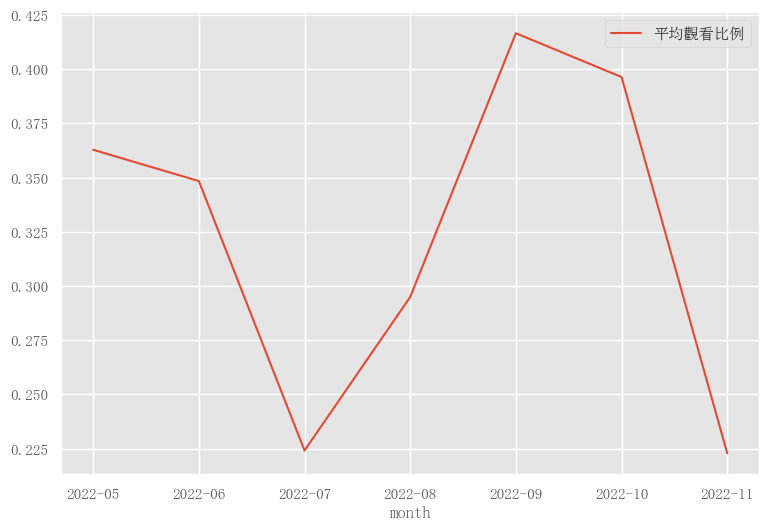

In [ ]:
dm=d3.groupby('month').mean().reset_index()
dm[['month','平均觀看比例']].plot(x='month')
#PPT P6
# X軸為影片發布月份
# Y軸為該月影片的平均觀看比例取平均
# 七月特別低

<AxesSubplot: xlabel='month'>

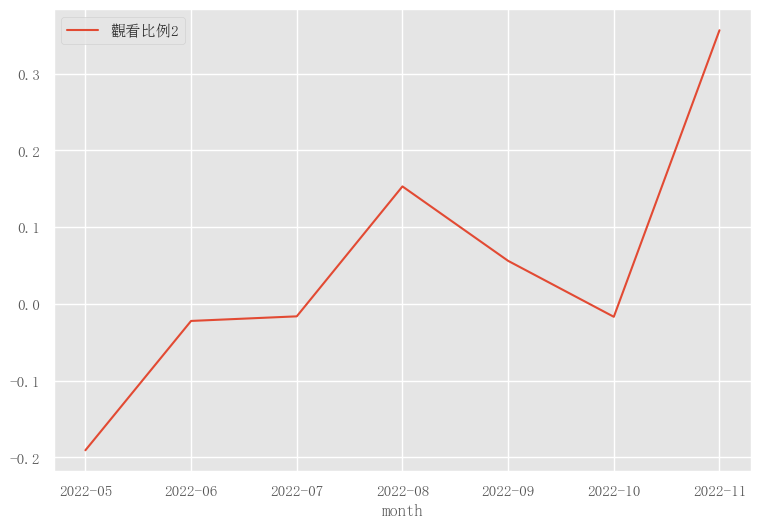

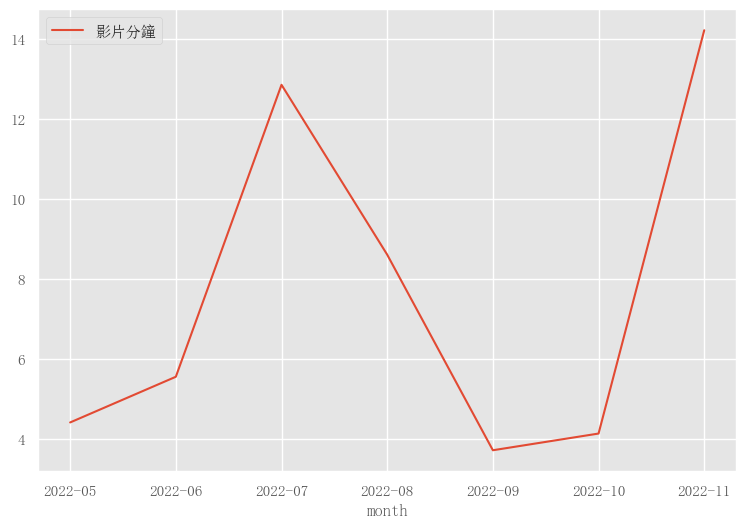

In [ ]:
dm[['month','觀看比例2']].plot(x='month')
dm[['month','影片分鐘']].plot(x='month')
# PPT P7
# Y軸為校正後的觀看比例
# 實際上七月的觀看比例沒有特別低(左圖)，只是七月的長片特別多(右圖)
# 而5月和6月的觀看比例特低也正常，因為頻道剛創立，還沒有穩定受眾